# A Two-Stage Sabermetrics Bayesian Model of Baseball Predictions

## AM207 Final Project
## Author: Thomas Leu

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string
import json

## Introduction

An [article](http://www.jds-online.com/v2-1) published in the Journal of Data Science in January 2001 attempts to 
build a Bayesian model for predicting baseball winners by comparing the winning percentage, batting average, and ERA 
(earned run average) of the opposing teams. These statistical measurements were widely used to compare teams and 
players until [Sabermetrics](http://sabr.org/sabermetrics/the-basics), an analysis of baseball statistics championed
by Bill James and popularized in the book [Moneyball](https://en.wikipedia.org/wiki/Moneyball), began to replace these
traditional ranking systems. 

The following notebook attempts to recreate the statistical models built in Yang and Swartz's paper using OBP (on base 
percentage), 

$$
\Theta = \{r_{\alpha}, r_{\beta}, r_{\gamma},\delta\}
$$
$$
P(\Theta|X,D) = P(X,D|\Theta)P(\Theta) \propto \Sigma_s [X_s ln(\frac{\lambda_s \delta}{1 + \lambda_s \delta}) 
                                                        + (1-X_s)ln(\frac{1}{1+\lambda_s \delta})]
$$

In [5]:
# load 2014 postseason data
with open('2014_postseason.json', 'r') as infile:
    postseason_2014_str = infile.read()
    postseason_2014 = json.loads(postseason_2014_str)
    
num_games = len(postseason_2014['games'])
original_data = np.empty((num_games,3))
sabr_data = np.empty((num_games,3))
home_wins = np.empty(num_games)


pitchers = postseason_2014['pitchers']
teams = postseason_2014['teams']

def original_game_data(game):
    home = game['home']; away = game['away']
    era_ratio = pitchers[away['starter']]['era'] / pitchers[home['starter']]['era']
    batavg_ratio = teams[home['team']]['BAT_AVG'] / teams[away['team']]['BAT_AVG']
    win_ratio = teams[home['team']]['WIN_PCT'] / teams[away['team']]['WIN_PCT']
    return np.array([era_ratio, batavg_ratio, win_ratio]), game['x']
    
def sabr_game_data(game):
    home = game['home']; away = game['away']
    fip_ratio = pitchers[away['starter']]['fip'] / pitchers[home['starter']]['fip']
    ops_ratio = teams[home['team']]['OPS'] / teams[away['team']]['OPS']
    win_ratio = teams[home['team']]['WIN_PCT'] / teams[away['team']]['WIN_PCT']
    return np.array([fip_ratio, ops_ratio, win_ratio]), game['x']

# build numpy data objects
for i in xrange(num_games):
    game = postseason_2014['games'][i]
    original_data[i], home_wins[i] = original_game_data(game)
    sabr_data[i], _ = sabr_game_data(game)

[ 0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.
  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.]


R1 acceptance: 0.086
R2 acceptance: 0.4586
R3 acceptance: 0.3008
Delta acceptance: 0.039


(array([  9.93800000e+03,   4.00000000e+00,   4.00000000e+00,
          8.00000000e+00,   5.00000000e+00,   1.20000000e+01,
          4.00000000e+00,   1.10000000e+01,   1.00000000e+01,
          5.00000000e+00]),
 array([   0.48715604,   29.72665341,   58.96615078,   88.20564815,
         117.44514552,  146.6846429 ,  175.92414027,  205.16363764,
         234.40313501,  263.64263238,  292.88212975]),
 <a list of 10 Patch objects>)

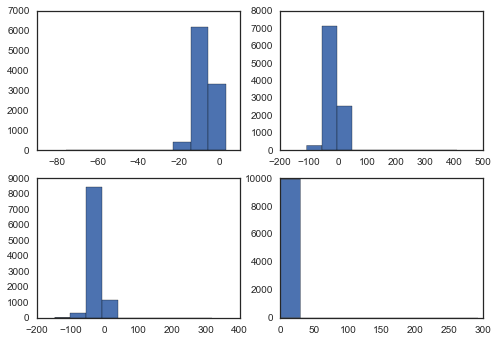

In [56]:
def model_1_log_likelihood(home_wins, ratios, weights, home_adv):
    '''Calculates the likelihood of the given parameters and data within
    log space
    
    --Keywords--
    :home_wins: A binary array with (x_s = 1) => home win in game s
    :ratios: An size (m,n) float array with the ratios of the home and away teams stats
    :weights: A size (1,n) float array with the weights for each statistical ratio
    :home_adv: A constant measuring home field advantage'''
    lambda_delta = np.prod(ratios ** weights,1) * home_adv
    return np.sum(home_wins*np.log(lambda_delta/(1+lambda_delta))+(1-home_wins)*np.log(1/(1+lambda_delta)))

###--------------###
### DRAW SAMPLES ###
###--------------###

# variables for drawing samples
num_samples = 10000
accepted = [0,0,0,0]
lower_bound = -500.
upper_bound = 500
step_size = 50


def draw_r(home_wins, ratios, weights, home_adv, index, accepted):
    # initial likelihood
    weight = weights[index]
    loglik = model_1_log_likelihood(home_wins, ratios, weights, home_adv)
    
    # new likelihood
    low = max(lower_bound, weight-step_size)
    high = min(upper_bound, weight+step_size)
    weights_star = weights.copy()
    weight_star = np.random.uniform(low=low, high=high)
    weights_star[index] = weight_star
    loglik_star = model_1_log_likelihood(home_wins, ratios, weights_star, home_adv)

    # determine acceptance
    if loglik_star - loglik >= np.log(np.random.uniform()):
        accepted[index] += 1
        return weight_star
    return weight

def draw_delta(home_wins, ratios, weights, delta, accepted):
    low = max(lower_bound, delta-step_size)
    high = min(upper_bound, delta+step_size)
    delta_star = np.random.uniform(low=low, high=high)
    loglik = model_1_log_likelihood(home_wins, ratios, weights, delta)
    loglik_star = model_1_log_likelihood(home_wins, ratios, weights, delta_star)
    
    if loglik_star - loglik >= np.log(np.random.uniform()):
        accepted[-1] += 1
        return delta_star
    return delta

# samples = np.zeros((num_samples+1,4)) # add one for initial sample
# samples[0] = np.random.uniform(high=upper_bound,size=4)


# # original paper sampling
# for i in xrange(1, num_samples+1):
#     sample = samples[i-1].copy()
#     sample[0] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 0, accepted) # r_alpha_s
#     sample[1] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 1, accepted) # r_beta_s
#     sample[2] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 2, accepted) # r_gamma_s
#     sample[3] = draw_delta(home_wins, original_data, sample[:-1], sample[-1], accepted)
#     samples[i] = sample
# print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
# print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
# print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
# print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
# plt.hist(samples[:,3])    

samples = np.zeros((num_samples+1,4)) # add one for initial sample
samples[0] = np.random.uniform(high=upper_bound,size=4)
accepted = [0,0,0,0]

for i in xrange(1, num_samples+1):
    sample = samples[i-1].copy()
    sample[0] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 0, accepted) # r_alpha_s
    sample[1] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 1, accepted) # r_beta_s
    sample[2] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 2, accepted) # r_gamma_s
    sample[3] = draw_delta(home_wins, sabr_data, sample[:-1], sample[-1], accepted)
    samples[i] = sample
print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
plt.subplot(2,2,1).hist(samples[:,0])
plt.subplot(2,2,2).hist(samples[:,1])
plt.subplot(2,2,3).hist(samples[:,2])
plt.subplot(2,2,4).hist(samples[:,3])

In [37]:
print len(home_wins)
np.sum(home_wins)/len(home_wins)

32


0.53125